# Back-testing Hourly Dynamic Minting Strategy with DDPG Model

In [1]:
import random
import time
import pandas as pd
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from datetime import datetime

from api.definer.core import *
from api.definer.ddpg import *
from api.definer.data import graph

import warnings
warnings.simplefilter("ignore")
mpl.style.use('default')

In [2]:
random_state = 0
random.seed(random_state)
np.random.seed(random_state)
torch.random.manual_seed(random_state)

print('Set random seed: {}'.format(random_state))

Set random seed: 0


In [3]:
LIVE = False
SAVE = True

## Collect Historical Data in USDC-ETH 0.05% Uniswap V3 pool

In [4]:
# USDC-ETH 0.05% Uniswap V3 pool on Ethereum chain
if LIVE:
    address = "0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640"
    after = '2022-01-01'
    dpd = graph(address, int(datetime.timestamp(datetime.strptime(after, "%Y-%m-%d"))))
    # dpd.to_csv('./data/uniswap_v3_usdc_eth.csv')
else:
    dpd = pd.read_csv('./data/uniswap_v3_usdc_eth.csv', index_col=[0])

In [5]:
decimal0 = dpd.iloc[0]['pool.token0.decimals']
decimal1 = dpd.iloc[0]['pool.token1.decimals']
decimal = decimal1 - decimal0
dpd['fg0'] = ((dpd['feeGrowthGlobal0X128']) / (2 ** 128)) / (10 ** decimal0)
dpd['fg1'] = ((dpd['feeGrowthGlobal1X128']) / (2 ** 128)) / (10 ** decimal1)
dpd['fg0shift'] = dpd['fg0'].shift(-1)
dpd['fg1shift'] = dpd['fg1'].shift(-1)
dpd['fee0token'] = dpd['fg0'] - dpd['fg0shift']
dpd['fee1token'] = dpd['fg1'] - dpd['fg1shift']
print('starting price:', dpd['close'].iloc[-1])

starting price: 1995.8472015960615


In [6]:
base = 0
n = 1
mini = 1900
maxi = 2250
target = dpd['close'].iloc[-1] * n

In [7]:
SMIN, SMAX = np.sqrt(mini * 10 ** decimal), np.sqrt(maxi * 10 ** decimal)
amount0, amount1, deltaL = get_initial_wealth(base, dpd, decimal, SMIN, SMAX, target)
liq = get_liquidity(dpd['price0'].iloc[-1], mini, maxi, amount0, amount1, decimal0, decimal1)
dpd = get_fee(dpd, base, mini, maxi, liq, decimal0, decimal1, decimal)

In [8]:
p_std = dpd.close.std()
v_std = dpd.amountV.std()
p_mean = dpd.close.mean()
v_mean = dpd.amountV.mean()

## Load Trained DDPG Model

In [9]:
EPISODES = 2
EP_STEPS = 1000 - 2
MEMORY_CAPACITY = 500

tau = 500

s_dim = 2
a_dim = 2
a_high_bound = 10
a_low_bound = -10

ddpg = DDPG(a_dim, s_dim, a_high_bound)

ddpg.actor_eval.load_state_dict(torch.load('./results/ddpg_actor_eval.pt'))
ddpg.actor_target.load_state_dict(torch.load('./results/ddpg_actor_target.pt'))
ddpg.critic_eval.load_state_dict(torch.load('./results/ddpg_critic_eval.pt'))
ddpg.critic_target.load_state_dict(torch.load('./results/ddpg_critic_target.pt'))

<All keys matched successfully>

In [10]:
dpd_step = dpd.copy()

a_list = []

s = np.array([
    (dpd.iloc[-1].close - p_mean) / p_std,
    (dpd.iloc[-1].amountV - v_mean) / v_std
])

ep_r = 0
r = 0
eta = 0.01

price_mark = dpd_step.iloc[-1].close

pbar = tqdm(range(EP_STEPS))
for j in pbar:
    
    step_dict = {}
    pbar.set_description("step reward: {} \t".format(round(r, 3)))
    
    dpd_step = dpd_step.iloc[:-1]
    price_now = dpd_step.iloc[-1].close
    
    if abs(price_now - price_mark) > tau:
        
        target = (1 - eta) * dpd_step['amountV'].iloc[-1]
        
        # p_mean = dpd_step.iloc[-1].close
        # v_mean = dpd_step.iloc[-1].amountV
        
        a = ddpg.choose_action(s)
        a = np.clip(np.random.normal(a, 0), a_low_bound, a_high_bound)
        (a[0], a[1]) = (a[1], a[0]) if a[0] > a[1] else (a[0], a[1])
        if a[0] == a[1]: a[1] += 0.000001
    
        action = a * p_std + dpd_step.iloc[-1].close
        mini, maxi = action[0], action[1]
        SMIN, SMAX = np.sqrt(mini * 10 ** decimal), np.sqrt(maxi * 10 ** decimal)
        
        amount0, amount1, deltaL = get_initial_wealth(base, dpd_step, decimal, SMIN, SMAX, target)
        liq = get_liquidity(dpd_step['price0'].iloc[-1], mini, maxi, amount0, amount1, decimal0, decimal1)
        dpd_step = get_fee(dpd_step, base, mini, maxi, liq, decimal0, decimal1, decimal)
        
        price_mark = price_now
    
    step_dict['mini'] = mini
    step_dict['maxi'] = maxi
    step_dict['price'] = dpd_step['close'].iloc[-1]
    
    state_next = dpd_step.iloc[-2]
    s_ = np.array([
        (state_next.close - p_mean) / p_std,
        (state_next.amountV - v_mean) / v_std
    ])
    r = state_next.feeusd
        
    s = s_
    ep_r += r
    
    step_dict['feeusd'] = r 
    a_list.append(step_dict)

step reward: 0.117 	: 100%|██████████| 998/998 [00:01<00:00, 499.33it/s]


In [11]:
if SAVE: pd.DataFrame(a_list).to_csv('./results/ddpg_actions_tau{}.csv'.format(tau))

## Visualization

In [12]:
df = pd.read_csv('./results/ddpg_actions_tau{}.csv'.format(tau), index_col=[0])
# df = pd.DataFrame(a_list)

dpd = pd.read_csv('./data/uniswap_v3_usdc_eth.csv', index_col=[0])
dpd['datetime'] = pd.to_datetime(dpd['periodStartUnix'], unit='s')
# dpd.sort_values('datetime').iloc[1:-1]

df = pd.concat([df, dpd.sort_values('datetime').iloc[1:-1].reset_index(drop=True)], axis=1)
df.head()

,mini,maxi,price,feeusd,periodStartUnix,liquidity,high,low,close,feeGrowthGlobal0X128,feeGrowthGlobal1X128,pool.totalValueLockedUSD,pool.totalValueLockedToken1,pool.totalValueLockedToken0,pool.token0.decimals,pool.token1.decimals,datetime
0,1900,2250,2014.490845,0.047487,1.701119e+09,2.582512e+19,2017.917074,1995.832184,2014.490845,2.500188e+33,1.213144e+42,3.823225e+08,74638.971438,2.163832e+08,6.0,18.0,2023-11-27 21:00:00
1,1900,2250,2021.155534,0.059425,1.701122e+09,2.569357e+19,2021.157388,2013.370696,2021.155534,2.500210e+33,1.213149e+42,3.823225e+08,74638.971438,2.163832e+08,6.0,18.0,2023-11-27 22:00:00
2,1900,2250,2027.494168,0.096277,1.701126e+09,2.584512e+19,2028.429981,2021.134907,2027.494168,2.500234e+33,1.213155e+42,3.823225e+08,74638.971438,2.163832e+08,6.0,18.0,2023-11-27 23:00:00
3,1900,2250,2033.964624,0.038038,1.701130e+09,2.279386e+19,2038.939967,2024.358686,2033.964624,2.500271e+33,1.213167e+42,3.823225e+08,74638.971438,2.163832e+08,6.0,18.0,2023-11-28 00:00:00
4,1900,2250,2027.757645,0.056539,1.701133e+09,2.588521e+19,2033.957109,2025.841723,2027.757645,2.500277e+33,1.213176e+42,3.823225e+08,74638.971438,2.163832e+08,6.0,18.0,2023-11-28 01:00:00


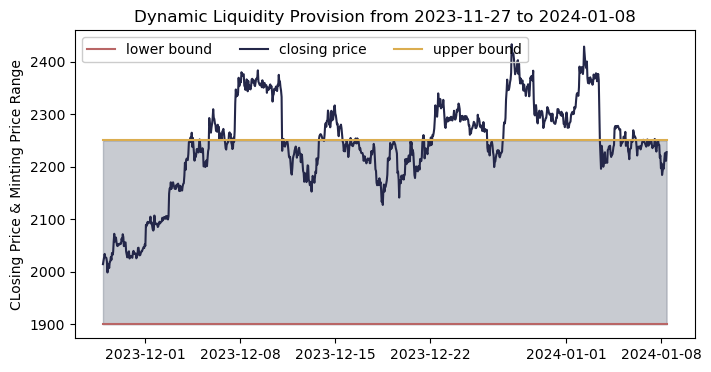

In [13]:
_ = plt.figure(figsize=(8,4))
ax = sns.lineplot(x=df.datetime, y=df.mini, label='lower bound', color='#B96666')
sns.lineplot(x=df.datetime, y=df.price, label='closing price', color='#242749', linestyle='-')
sns.lineplot(x=df.datetime, y=df.maxi, label='upper bound', color='#DBAD4F')
ax.fill_between(df.datetime, list(df.mini), list(df.maxi), color='#4B5569', alpha=0.3)

plt.rcParams.update({'font.sans-serif':'DejaVu Sans'})

plt.title('Dynamic Liquidity Provision from {} to {}'.format(
    datetime.utcfromtimestamp(dpd.periodStartUnix.min()).strftime('%Y-%m-%d'), 
    datetime.utcfromtimestamp(dpd.periodStartUnix.max()).strftime('%Y-%m-%d')))
plt.ylabel('CLosing Price & Minting Price Range')
plt.xlabel(None)
legend = plt.legend(ncol=3)
legend.get_frame().set_alpha(None)
legend.get_frame().set_facecolor((0, 0, 0, 0))
if SAVE: plt.savefig('./img/dynamic_minting_tau{}.png'.format(tau), dpi=500, bbox_inches='tight', transparent=True)
plt.show()

In [14]:
print('Total fee earnings estimated with dynamic minting using DDPG:', round(df.feeusd.sum(), 2))

Total fee earnings estimated with dynamic minting using DDPG: 89.16
